In [1]:
import dask.dataframe as dd
import pandas as pd

In [2]:
from dask.distributed import Client, progress, LocalCluster
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 31.85 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51072,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 31.85 GiB
Comm: tcp://127.0.0.1:51099,Total threads: 4
Dashboard: http://127.0.0.1:51100/status,Memory: 7.96 GiB
Nanny: tcp://127.0.0.1:51076,


<center>
    <h3>Library</h3>
</center>

In [3]:
# general tools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import re
import datetime as dt
import json
import requests
import scipy as sp
import numpy as np
import tempfile
import random
import time
import math
import statistics
import os
from typing import Tuple, Dict, List
import sys
import warnings
warnings.filterwarnings('ignore')

# preprocessing & utils
import nltk
from nltk import pos_tag
from nltk import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# ml models
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier

# others
from wordcloud import WordCloud
from matplotlib.ticker import FormatStrFormatter

<center>
    <h3>Constant</h3>
</center>

In [4]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

<center>
    <h3>Utility Function</h3>
</center>

In [5]:
# processsing
def pipe_cleaningText(text: str) -> str:
    txt = text.lower()
    return txt

def pipe_removeStopWords(text: str, tokenized: bool = False) -> str:
    if tokenized:
        return " ".join([w for w in text.split(" ") if w not in stop_words])
    return " ".join([w for w in word_tokenize(text) if w not in stop_words])

def pipe_lemmatization(text: str, tokenized: bool = False) -> str:
    txt = ""
    collections = word_tokenize(text) if not tokenized else text.split(" ")
    for w in collections:
        txt += lemmatizer.lemmatize(w) + ' '
    return txt.strip()

def pipe_addPos(text: str, tokenized: bool = False) -> str:
    txt = ""
    collections = word_tokenize(text) if not tokenized else text.split(" ")
    for w in pos_tag(collections):
        txt += '__'.join(w) + ' '
    return txt.strip()

def pipe_normalized(text: str, bin: int, tokenized: bool = False) -> str:
    txt = ""
    collections = word_tokenize(text) if not tokenized else text.split(" ")
    n = len(collections)
    for i, w in enumerate(collections):
        normVal = math.floor((i / (n - 1)) * (bin - 1)) + 1 if n != 1 else 1
        txt += w + '__' + str(normVal) + ' '
    return txt.strip()

def pipe_subjectCleaning(text: str, tokenized: bool = False) -> str:
    txt = ""
    collections = sent_tokenize(text) if not tokenized else text.split(" ")
    for s in collections:
        for w in pos_tag(word_tokenize(s)):
            if w[1] != 'NNP':
                continue
            txt += w[0] + ' '
    return txt.strip()

# feature extraction
def feature_tfidfUni(series: pd.Series, max_features=None) -> Tuple[sp.sparse.csr_matrix, TfidfVectorizer]:
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=max_features)
    tfidf_vectorizer.fit(series)
    return tfidf_vectorizer.transform(series), tfidf_vectorizer

def feature_bowUni(series: pd.Series, max_features=None) -> Tuple[sp.sparse.csr_matrix, CountVectorizer]:
    bow_vectorizer = CountVectorizer(ngram_range=(1,1), max_features=max_features)
    bow_vectorizer.fit(series)
    return bow_vectorizer.transform(series), bow_vectorizer

def feature_tfidfUniBi(series: pd.Series, max_features=None) -> Tuple[sp.sparse.csr_matrix, TfidfVectorizer]:
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=max_features)
    tfidf_vectorizer.fit(series)
    return tfidf_vectorizer.transform(series), tfidf_vectorizer

def feature_bowUniBi(series: pd.Series, max_features=None) -> Tuple[sp.sparse.csr_matrix, CountVectorizer]:
    bow_vectorizer = CountVectorizer(ngram_range=(1,2), max_features=max_features)
    bow_vectorizer.fit(series)
    return bow_vectorizer.transform(series), bow_vectorizer

# sampling
def balancing_upsampling(data: pd.DataFrame, target: int=None) -> pd.DataFrame:
    group_res = data.groupby(by=['overall'])['overall'].count()
    highest_n = max(group_res.values) if not target else target
    thedata = data[data.overall == group_res[group_res == highest_n].index[0]] if not target else data.drop(data.index)
    for i in group_res.index:
        if group_res.loc[i] == highest_n:
            continue
        tdata = data[data.overall == i]
        sample_ind = np.random.choice(tdata.index, highest_n - group_res.loc[i], replace=True)
        thedata = pd.concat([thedata, tdata, tdata.loc[sample_ind]])
    return thedata

def balancing_downsampling(data: pd.DataFrame, target: int=None) -> pd.DataFrame:
    group_res = data.groupby(by=['overall'])['overall'].count()
    lowest_n = min(group_res.values) if not target else target
    thedata = data[data.overall == group_res[group_res == lowest_n].index[0]] if not target else data.drop(data.index)
    for i in group_res.index:
        if group_res.loc[i] == lowest_n:
            continue
        tdata = data[data.overall == i]
        sample_ind = np.random.choice(tdata.index, lowest_n, replace=False)
        thedata = pd.concat([thedata, tdata.loc[sample_ind]])
    return thedata

# testing
def accuracyTrainTest(model, trainX: np.array, trainY: np.array, valX: np.array, valY: np.array, testX: np.array, testY: np.array) -> Tuple[float, float, float]:
    mod = model.fit(trainX, trainY)
    yfit = mod.predict(trainX)
    ypredVal = mod.predict(valX)
    ypredTest = mod.predict(testX)
    
    # train result, validation result, test result
    return accuracy_score(trainY, yfit), accuracy_score(valY, ypredVal), accuracy_score(testY, ypredTest)
    
def loop_testing(model, n_test: int, xArr: sp.sparse.csr_matrix, yArr: np.array, testXArr: sp.sparse.csr_matrix, testYArr: np.array) -> Dict[str, List[float]]:
    thedict = {}

    i = 0
    n = xArr.shape[0]
    n_sample = math.ceil(n / n_test)
    x_sam, y_sam = np.array([]), np.array([])
    while i < n_test:
        percent_sample = n_sample/xArr.shape[0]
        if percent_sample >= 1:
            xmain, ymain = xArr, yArr
        else:
            xmain, xArr, ymain, yArr = train_test_split(xArr, yArr, train_size=percent_sample, stratify=yArr, random_state=123)
        
        x_sam = sp.sparse.vstack((x_sam, xmain)) if x_sam.shape[0] != 0 else xmain
        y_sam = np.hstack((y_sam, ymain)) if y_sam.shape[0] != 0 else ymain
        xtrain, xtest, ytrain, ytest = train_test_split(x_sam, y_sam, train_size=0.9, stratify=y_sam, random_state=123)

        resTrain, resVal, resTest = accuracyTrainTest(model, xtrain, ytrain, xtest, ytest, testXArr, testYArr)
        thedict[x_sam.shape[0]] = [resTrain, resVal, resTest]

        i += 1
    return thedict

# visualization
def show_result(ypred: np.array, ytarget: np.array) -> None:
    label = ['Positive', 'Neutral', 'Negative']
    report = classification_report(ypred, ytarget, labels=label)
    conf_matrix = confusion_matrix(ypred, ytarget, labels=label)

    group_names = ['True Pos', 'False Neu', 'False Neg',
                   'False Pos', 'True Neu', 'False Neg',
                   'False Pos', 'False Neu', 'True Neg']
    group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten() / np.sum(conf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_percentages, conf_matrix.flatten())]
    labels = np.asarray(labels).reshape(3, 3)

    df_cm = pd.DataFrame(data=conf_matrix, index=label, columns=label)

    print(report)
    fix, axe = plt.subplots(figsize=(15, 8), nrows=1, ncols=1)
    sns.heatmap(df_cm, xticklabels=label, yticklabels=label, annot=labels, ax=axe, cmap = 'Blues', fmt = '')
    plt.show();

def visualized_loopTesting(result_loopTesting: Dict[str, List[float]]) -> None:
    train_res, val_res, test_res = dict(), dict(), dict()
    for res in result_loopTesting:
        train_res[res] = result[res][0]
        val_res[res] = result[res][1]
        test_res[res] = result[res][2]

    fig, axe = plt.subplots(figsize=(15, 8), nrows=1, ncols=1)
    sns.lineplot(y=train_res.values(), x=train_res.keys() , ax=axe, label='train-result')
    sns.lineplot(y=val_res.values(), x=val_res.keys(), ax=axe, label='val-result')
    sns.lineplot(y=test_res.values(), x=test_res.keys(), ax=axe, label='test-result')
    axe.set_title("Highest Score: {}".format(max(test_res.values())))
    axe.set_xlabel("Dataset Size")
    axe.set_ylabel("Accuracy")
    axe.set_ylim([0.65, 1.0])
    axe.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    plt.show();

# others
def correlation(x: list, y: list) -> float:
    x = np.array(x)
    y = np.array(y)
    bar_x = x.mean()
    bar_y = y.mean()
    sum_xixbar_yiybar = sum((x - bar_x) * (y - bar_y))
    sum_xixbar2 = sum((x - bar_x) ** 2)
    sum_yiybar2 = sum((y - bar_y) ** 2)

    numer = sum_xixbar_yiybar
    denom = (sum_xixbar2 * sum_yiybar2) ** (1 / 2)

    r = numer / denom if denom != 0 else 0

    return r

def gradient(x: list, y: list) -> float:
    p1 = [x[0], y[0]]
    p2 = [x[2], y[2]]

    numer = p1[1] - p2[1]
    denom = p1[0] - p2[0]

    return numer / denom
    

<center>
    <h3>Exploration</h3>
</center>

In [6]:
df = pd.read_csv('../data/Amazon_Electronics.csv')

In [7]:
df.describe()

,overall,unixReviewTime
count,2.094154e+07,2.094154e+07
mean,4.073490e+00,1.425820e+09
std,1.385862e+00,7.772530e+07
min,1.000000e+00,8.811936e+08
25%,4.000000e+00,1.393891e+09
50%,5.000000e+00,1.440461e+09
75%,5.000000e+00,1.478563e+09
max,5.000000e+00,1.538698e+09


In [8]:
df.isnull().sum()

overall                  0
verified                 0
reviewTime               0
reviewerID               0
asin                     0
style             10476370
reviewerName          2668
reviewText            9670
summary               4896
unixReviewTime           0
vote              18254610
image             20594419
dtype: int64

<AxesSubplot:xlabel='overall'>

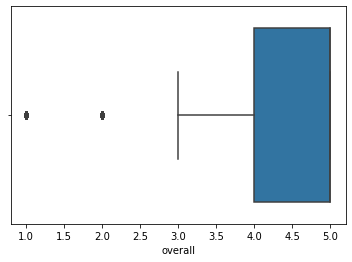

In [9]:
sns.boxplot(df['overall'])

<AxesSubplot:xlabel='overall', ylabel='Count'>

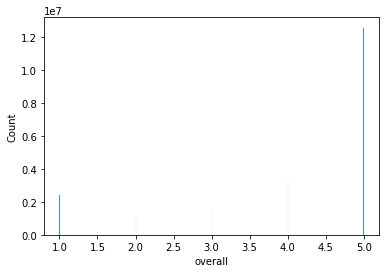

In [10]:
sns.histplot(df['overall'])

In [23]:
dfdata = df[['reviewText', 'overall']]
dfdata.head()

,reviewText,overall
0,This was the first time I read Garcia-Aguilera...,5
1,"As with all of Ms. Garcia-Aguilera's books, I ...",5
2,I've not read any of Ms Aguilera's works befor...,5
3,This romance novel is right up there with the ...,4
4,Carolina Garcia Aguilera has done it again. S...,5


In [24]:
dfdata.isnull().sum()

reviewText    9670
overall          0
dtype: int64

In [26]:
dfdata = dfdata[(~dfdata.isnull().any(axis=1)) & (dfdata.reviewText.apply(lambda x: str(x).strip() != ""))]

In [27]:
dfdata.isnull().sum()

reviewText    0
overall       0
dtype: int64

---

# !IMPORTANT (can modify)

In [28]:
if len(dfdata['overall'].unique()) != 3:
    dfdata['overallOri'] = dfdata['overall']
dfdata['overall'] = dfdata['overallOri'].apply(lambda x: "Positive" if x > 3 else "Negative" if x < 3 else "Neutral")

----

<AxesSubplot:xlabel='overall', ylabel='Count'>

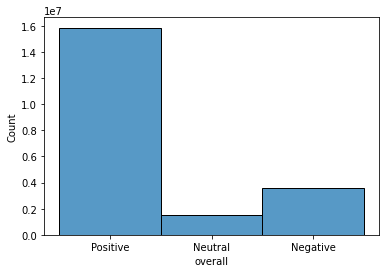

In [29]:
sns.histplot(dfdata['overall'])

In [30]:
target_n = 500 * 1000
dfdataMain, _ = train_test_split(dfdata, train_size=target_n / dfdata.shape[0], stratify=dfdata['overall'], random_state=123)

In [31]:
dfdataMain.shape

(500000, 3)

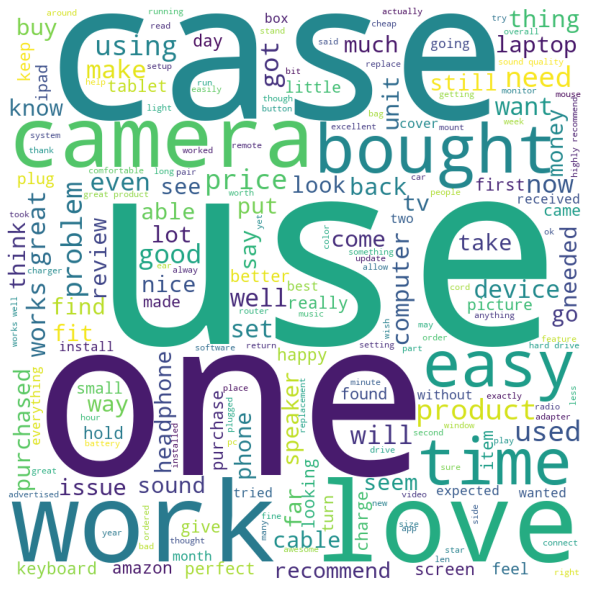

In [32]:
# show wordcloud for the overall text
words = ''
for i, tdf in dfdataMain.iterrows():
    words += ' ' + tdf['reviewText'].lower()

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

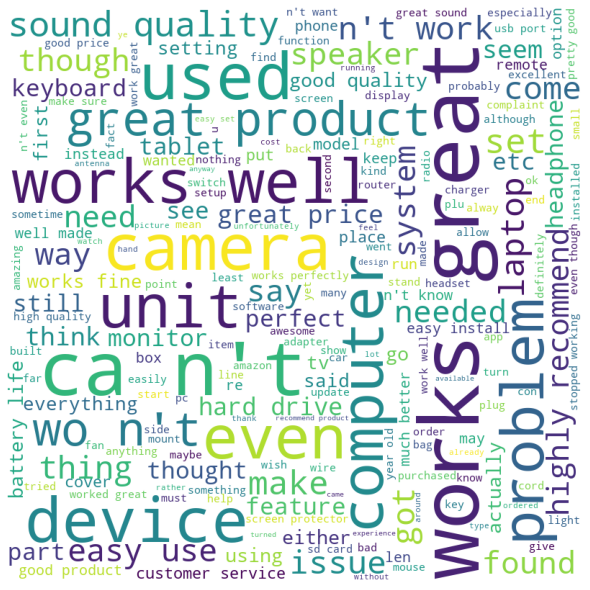

In [33]:
# show wordcloud for the overall text after removing stop words
words = ''
for i, tdf in dfdataMain.iterrows():
    words += ' ' + pipe_removeStopWords(tdf['reviewText'].lower())

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

<center>
    <h3>Process</h3>
</center>

In [34]:
# for training & testing
target_n = 450 * 1000
dfdataTrain, dfdataTest = train_test_split(dfdataMain, train_size=target_n / dfdataMain.shape[0], stratify=dfdataMain['overall'], random_state=123)

In [35]:
# for validation
target_n = 45 * 1000
dfdataValid, dfdataTrainSub = train_test_split(dfdataTrain, train_size=target_n / dfdataTrain.shape[0], stratify=dfdataTrain['overall'], random_state=123)

In [36]:
# for validation training & testing
target_n = 40 * 1000
dfdataValidTrain, dfdataValidTest = train_test_split(dfdataValid, train_size=target_n / dfdataValid.shape[0], stratify=dfdataValid['overall'], random_state=123)

In [37]:
dfdataValidTrain.shape

(40000, 3)

In [ ]:
statistics.variance(dfdataValidTrain.groupby(by=['overall'])['overall'].count().values)

In [63]:
# validation for processing

In [40]:
# upsampling minority group for validation training
if statistics.variance(dfdataValidTrain.groupby(by=['overall'])['overall'].count().values) >= 10 * 1000:
    dfdataValidTrain = balancing_upsampling(dfdataValidTrain)

<AxesSubplot:xlabel='overall', ylabel='Count'>

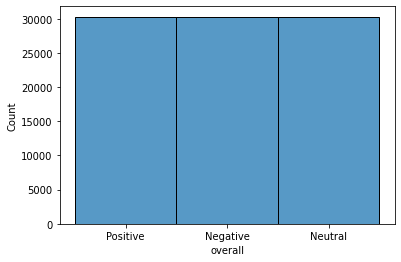

In [41]:
# sample resulf of sampling
sns.histplot(dfdataValidTrain['overall'])

In [42]:
statistics.variance(dfdataValidTrain.groupby(by=['overall'])['overall'].count().values)

0

In [66]:
# base nb model
nb_model = MultinomialNB()

Correlation last 3: 0.1144
Gradient last 3: 0.0003


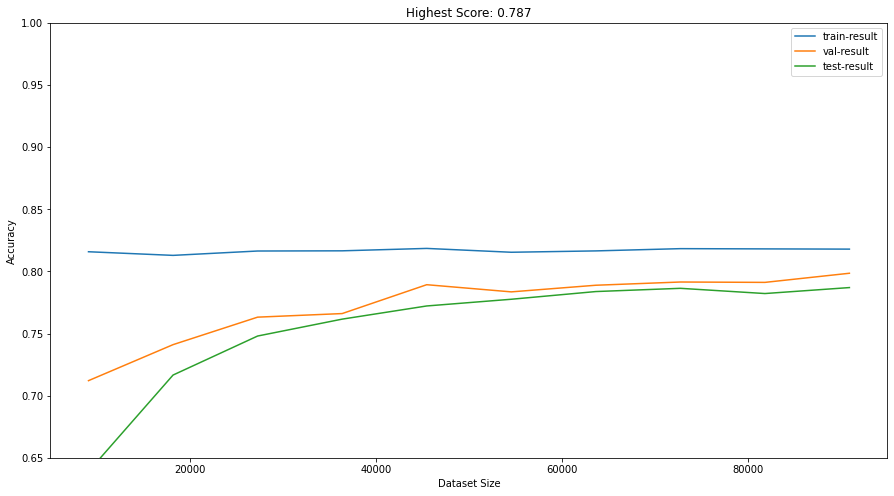

In [69]:
# pipeline 0: no preprocessing

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.1144
Gradient last 3: 0.0003


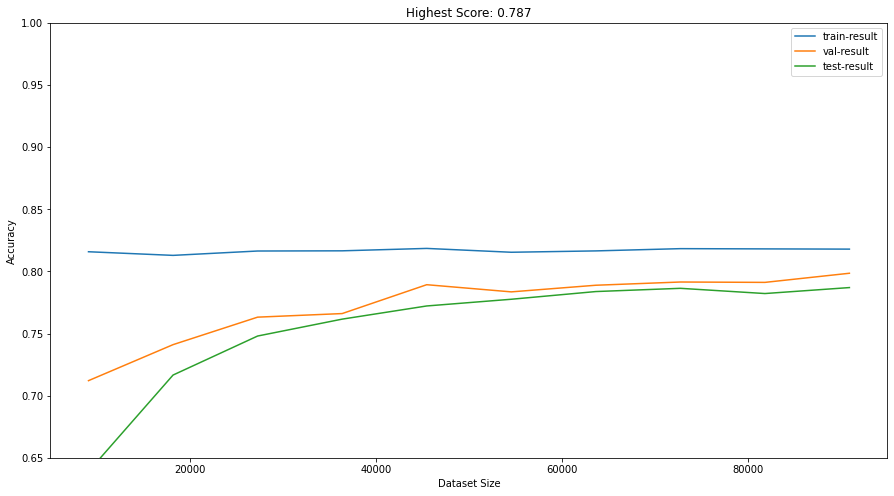

In [45]:
# pipeline 1: cleaningText
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.3271
Gradient last 3: 0.0001


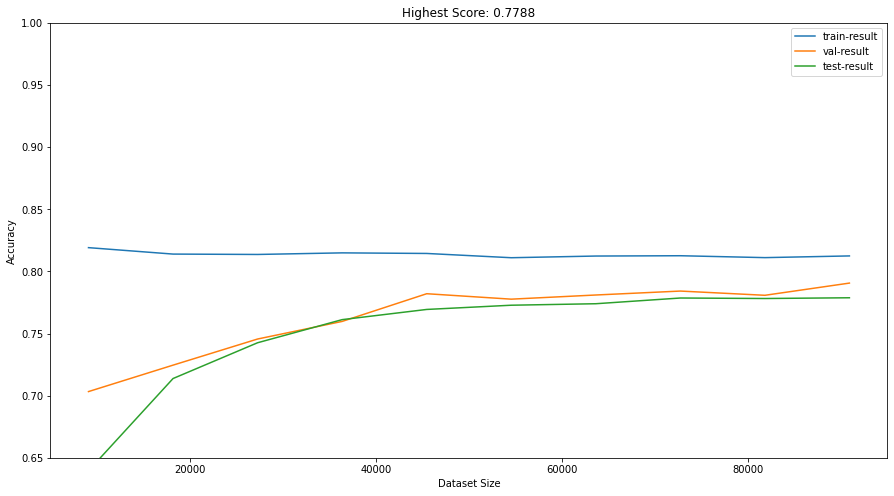

In [46]:
# pipeline 2: cleaningText -> removeStopWords
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_removeStopWords(txt)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.3709
Gradient last 3: 0.0006


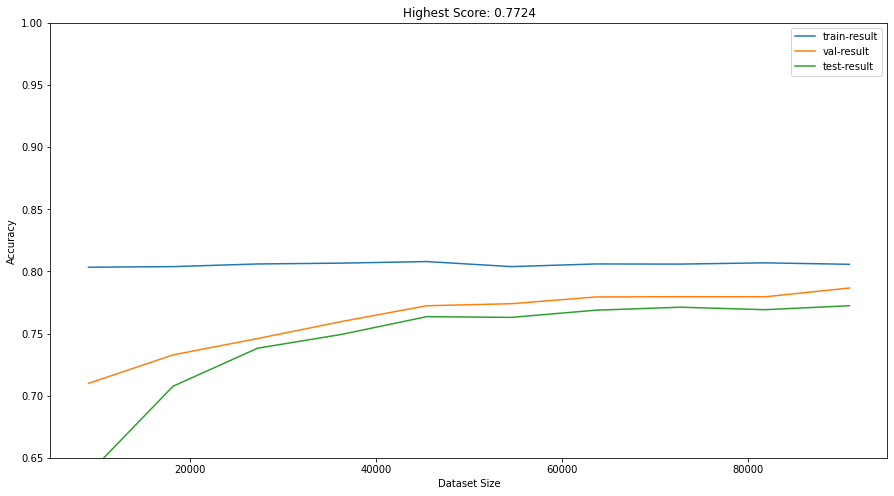

In [47]:
# pipeline 3: cleaningText -> lemmatized
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_lemmatization(txt)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.9210
Gradient last 3: 0.0015


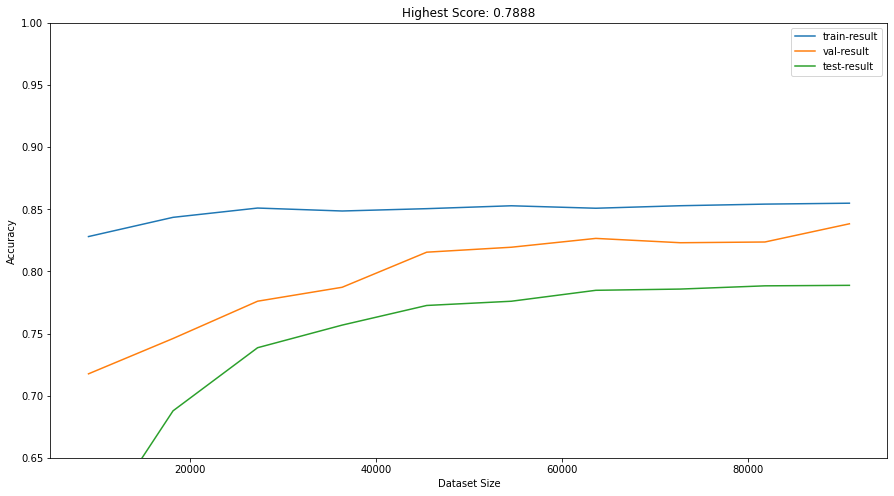

In [48]:
# pipeline 4: cleaningText -> addPos
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_addPos(txt)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.9334
Gradient last 3: 0.0006


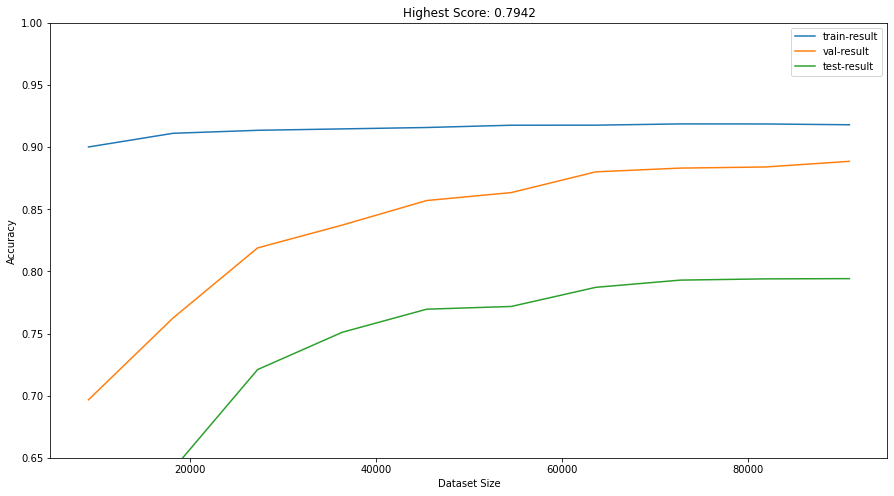

In [49]:
# pipeline 5: cleaningText -> normalized 10 position
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_normalized(txt, 10)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.7135
Gradient last 3: 0.0020


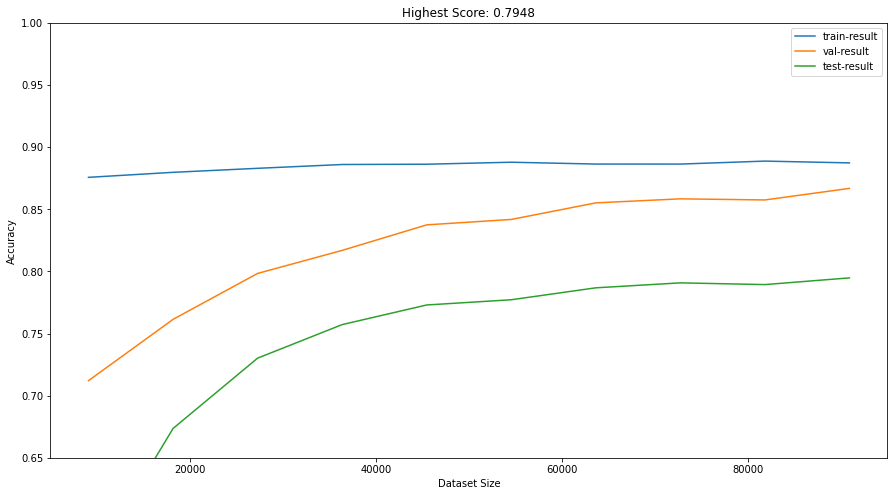

In [50]:
# pipeline 6: cleaningText -> normalized 5 position
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_normalized(txt, 5)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.9819
Gradient last 3: 0.0021


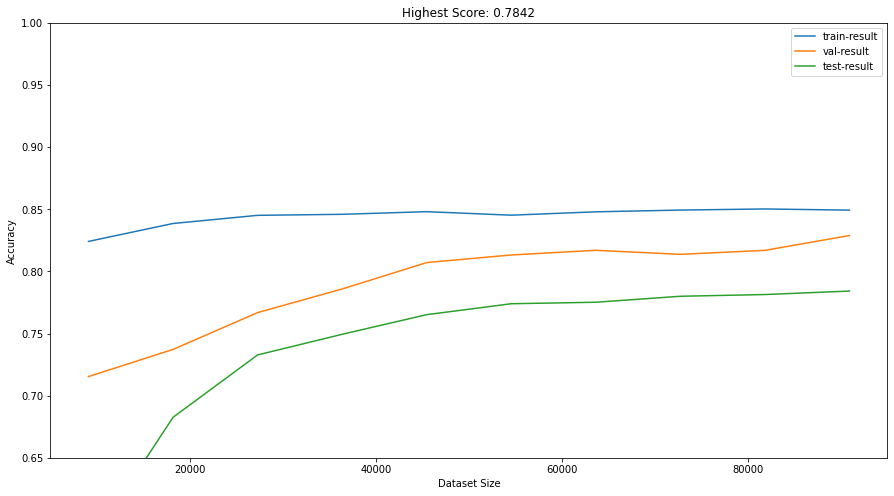

In [51]:
# pipeline 7: cleaningText -> lemmatized -> addPos
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_lemmatization(txt)
    txt = pipe_addPos(txt, tokenized=True)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.9521
Gradient last 3: 0.0018


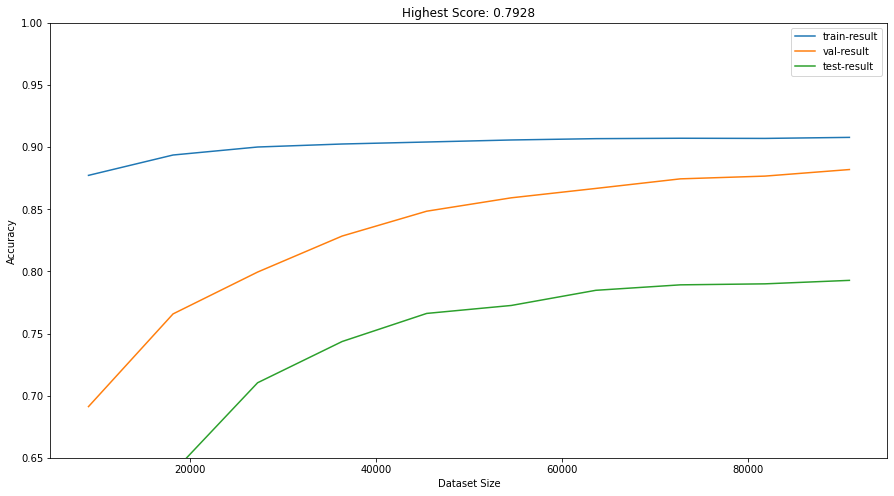

In [52]:
# pipeline 8: cleaningText -> lemmatized -> addPos -> normalized 5 position
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_lemmatization(txt)
    txt = pipe_addPos(txt, tokenized=True)
    txt = pipe_normalized(txt, 5, tokenized=True)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.8924
Gradient last 3: 0.0016


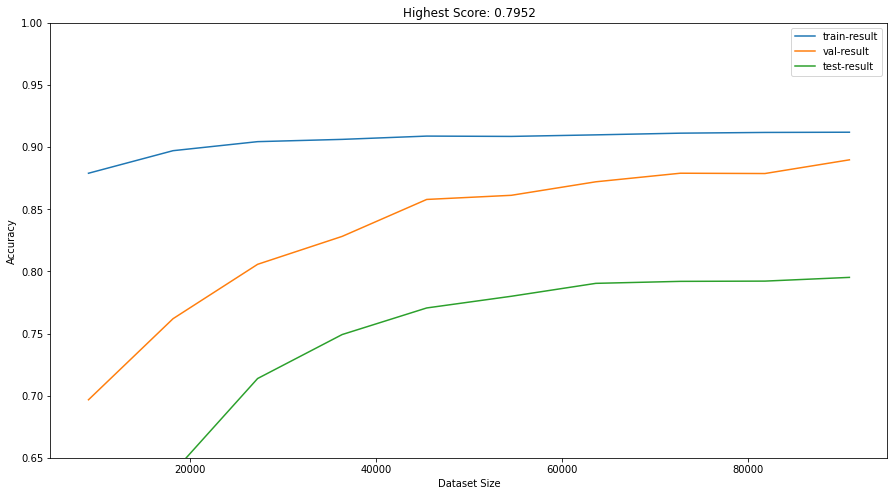

In [53]:
# pipeline 9: cleaningText -> addPos -> normalized 5 position
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_addPos(txt)
    txt = pipe_normalized(txt, 5, tokenized=True)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.6994
Gradient last 3: 0.0026


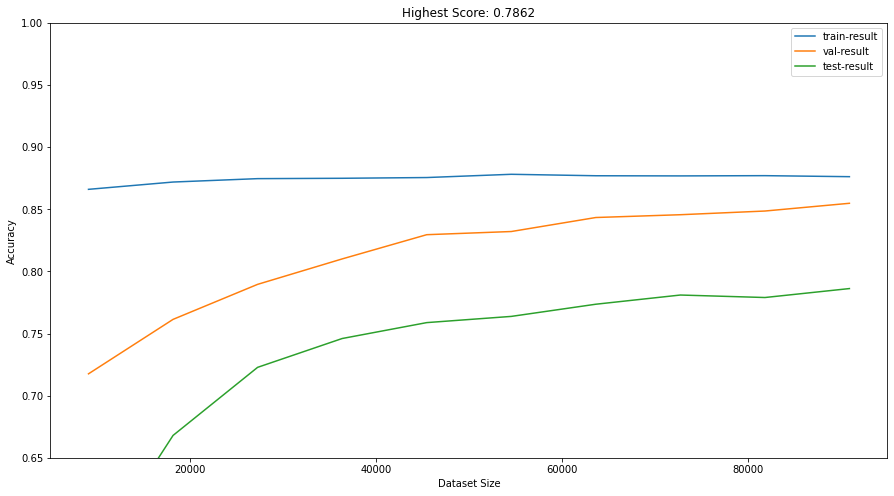

In [54]:
# pipeline 10: cleaningText -> lemmatized -> normalized 5 position
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_lemmatization(txt)
    txt = pipe_normalized(txt, 5, tokenized=True)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

In [55]:
# test on top 3

In [56]:
dfdataValid.shape

(45000, 3)

              precision    recall  f1-score   support

    Positive       0.95      0.89      0.92     36222
     Neutral       0.13      0.32      0.18      1317
    Negative       0.69      0.71      0.70      7461

    accuracy                           0.84     45000
   macro avg       0.59      0.64      0.60     45000
weighted avg       0.88      0.84      0.86     45000



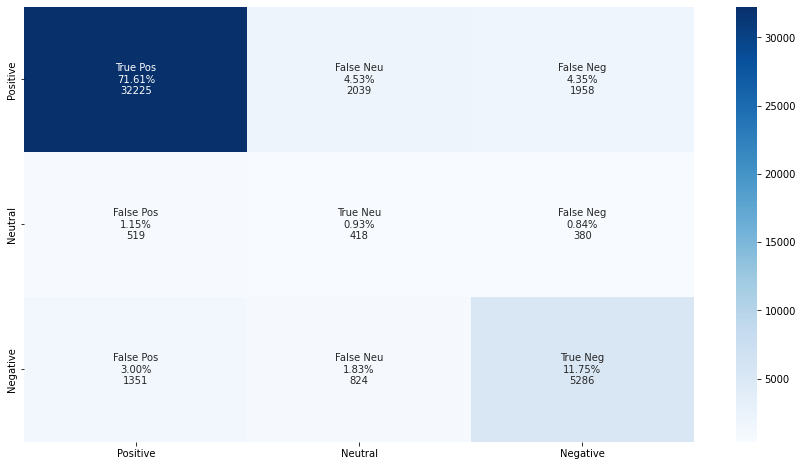

In [57]:
tdf1 = dfdataTrainSub.copy()
tdf2 = dfdataValid.copy()
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
nb_model.fit(xArr, yArr)
yHat = nb_model.predict(testXArr)
show_result(yHat, testYArr)

              precision    recall  f1-score   support

    Positive       0.97      0.88      0.92     37731
     Neutral       0.03      0.41      0.06       247
    Negative       0.69      0.75      0.72      7022

    accuracy                           0.85     45000
   macro avg       0.56      0.68      0.56     45000
weighted avg       0.92      0.85      0.88     45000



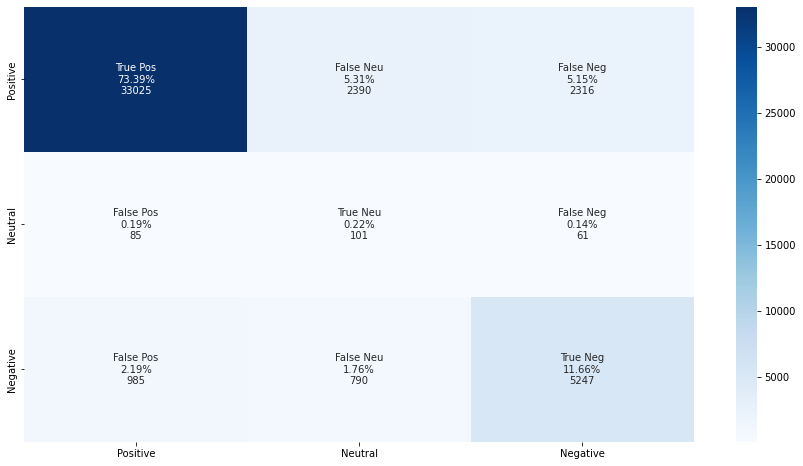

In [58]:
# option 1: cleaningText -> addPos -> Normalized
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_addPos(txt)
    txt = pipe_normalized(txt, 5, tokenized=True)
    return txt

tdf1 = dfdataTrainSub.copy()
tdf2 = dfdataValid.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
nb_model.fit(xArr, yArr)
yHat = nb_model.predict(testXArr)
show_result(yHat, testYArr)

              precision    recall  f1-score   support

    Positive       0.97      0.87      0.92     37811
     Neutral       0.03      0.43      0.06       238
    Negative       0.68      0.75      0.71      6951

    accuracy                           0.85     45000
   macro avg       0.56      0.68      0.56     45000
weighted avg       0.92      0.85      0.88     45000



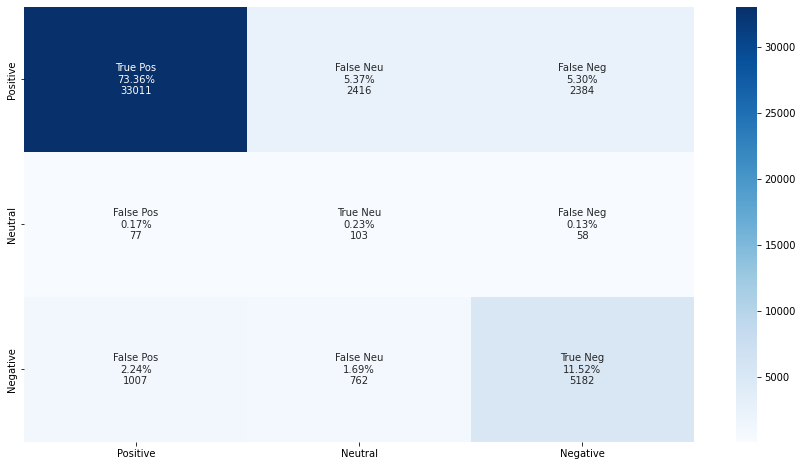

In [59]:
# option 2: cleaningText -> lemmatized -> addPos -> normalized
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_lemmatization(txt)
    txt = pipe_addPos(txt, tokenized=True)
    txt = pipe_normalized(txt, 5, tokenized=True)
    return txt

tdf1 = dfdataTrainSub.copy()
tdf2 = dfdataValid.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
nb_model.fit(xArr, yArr)
yHat = nb_model.predict(testXArr)
show_result(yHat, testYArr)

              precision    recall  f1-score   support

    Positive       0.97      0.87      0.92     37808
     Neutral       0.03      0.38      0.06       264
    Negative       0.68      0.75      0.71      6928

    accuracy                           0.85     45000
   macro avg       0.56      0.67      0.56     45000
weighted avg       0.92      0.85      0.88     45000



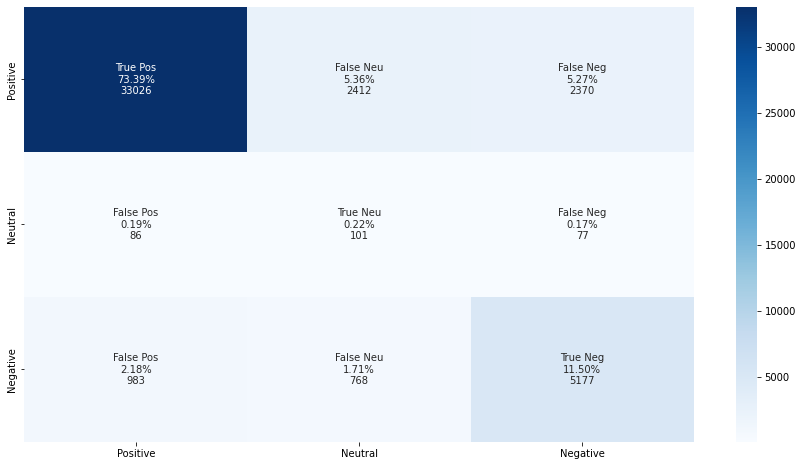

In [60]:
# option 3: cleaningText -> normalized
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_normalized(txt, 10)
    return txt

tdf1 = dfdataTrainSub.copy()
tdf2 = dfdataValid.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
nb_model.fit(xArr, yArr)
yHat = nb_model.predict(testXArr)
show_result(yHat, testYArr)

In [71]:
# test feature extraction

In [70]:
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_addPos(txt)
    txt = pipe_normalized(txt, 5, tokenized=True)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))

Correlation last 3: 0.8924
Gradient last 3: 0.0016


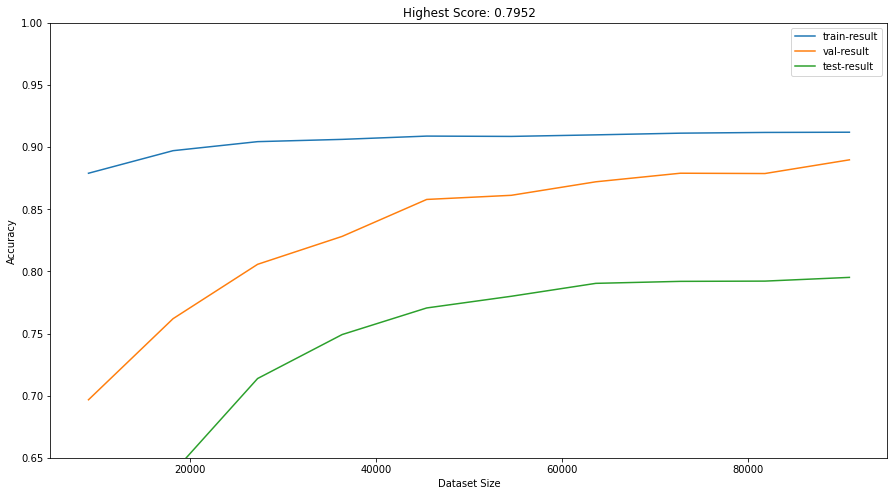

In [72]:
# feature 1: bow uni

xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.9984
Gradient last 3: 0.0051


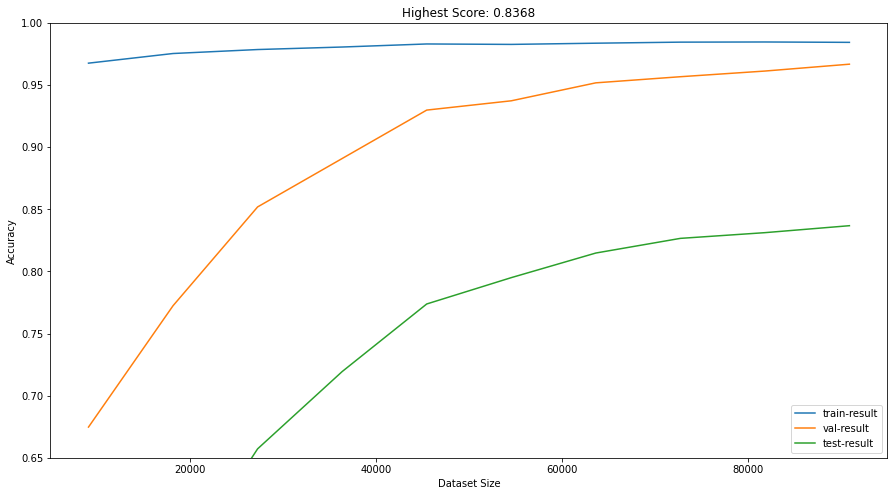

In [73]:
# feature 2: bow unibi

xArr, featureModel = feature_bowUniBi(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.9979
Gradient last 3: 0.0126


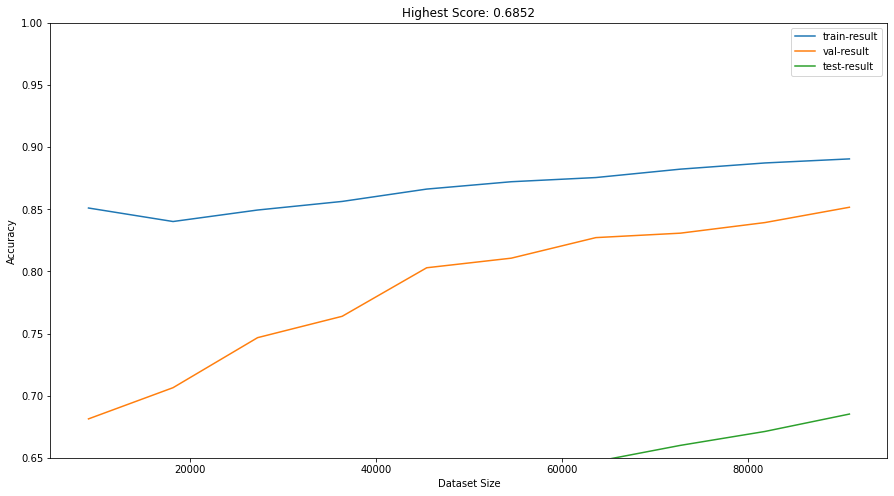

In [74]:
# feature 3: tfidf uni

xArr, featureModel = feature_tfidfUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.9980
Gradient last 3: 0.0137


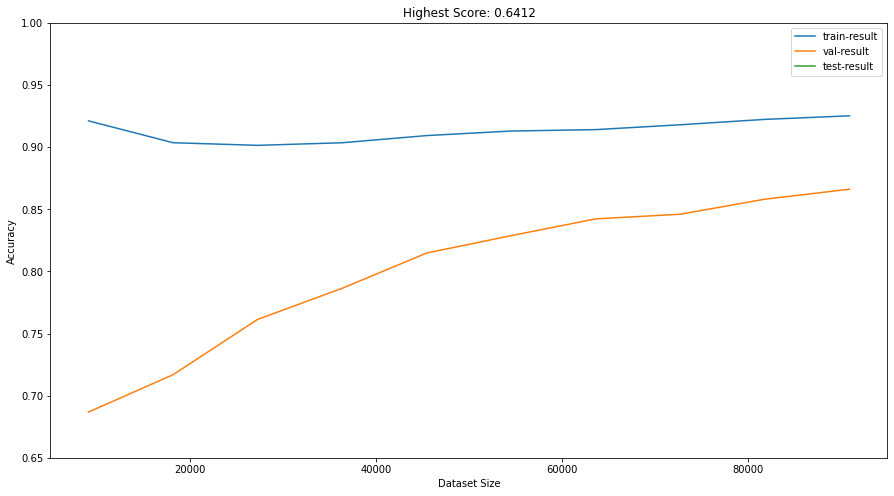

In [75]:
# feature 4: tfidf unibi

xArr, featureModel = feature_tfidfUniBi(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.9178
Gradient last 3: 0.0008


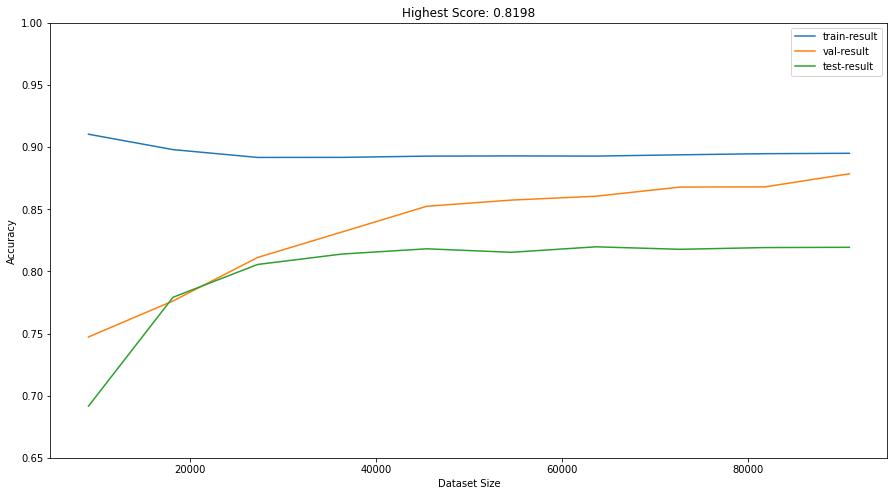

In [76]:
# feature 5: bow uni 50k

xArr, featureModel = feature_bowUni(tdf1['reviewText'], 50000)
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.7127
Gradient last 3: 0.0017


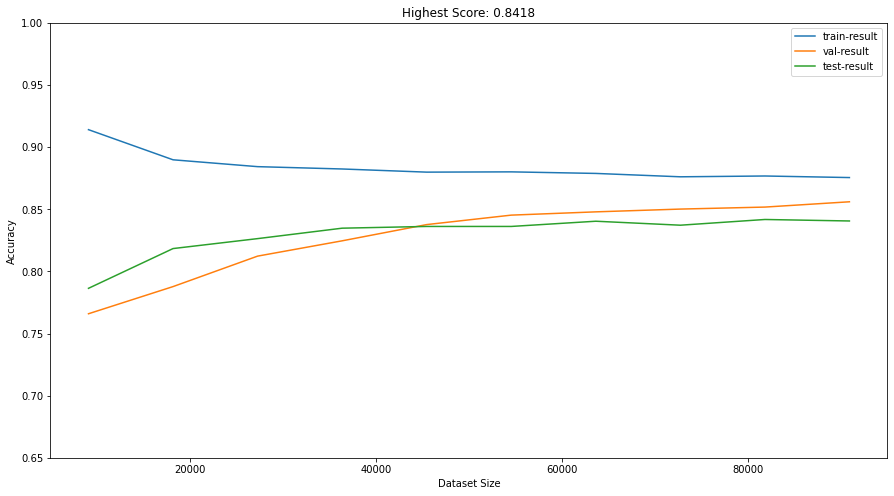

In [77]:
# feature 6: bow unibi 50k

xArr, featureModel = feature_bowUniBi(tdf1['reviewText'], 50000)
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.9995
Gradient last 3: 0.0055


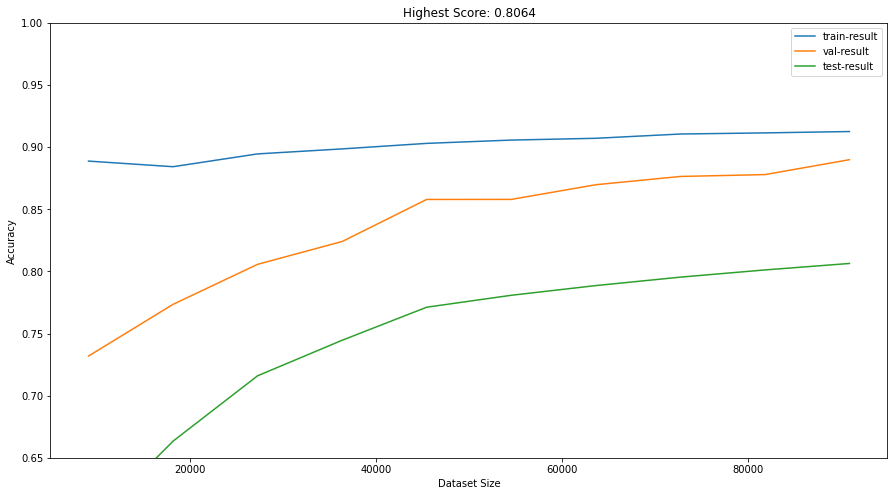

In [78]:
# feature 7: tfidf uni 50k

xArr, featureModel = feature_tfidfUni(tdf1['reviewText'], 50000)
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.9802
Gradient last 3: 0.0040


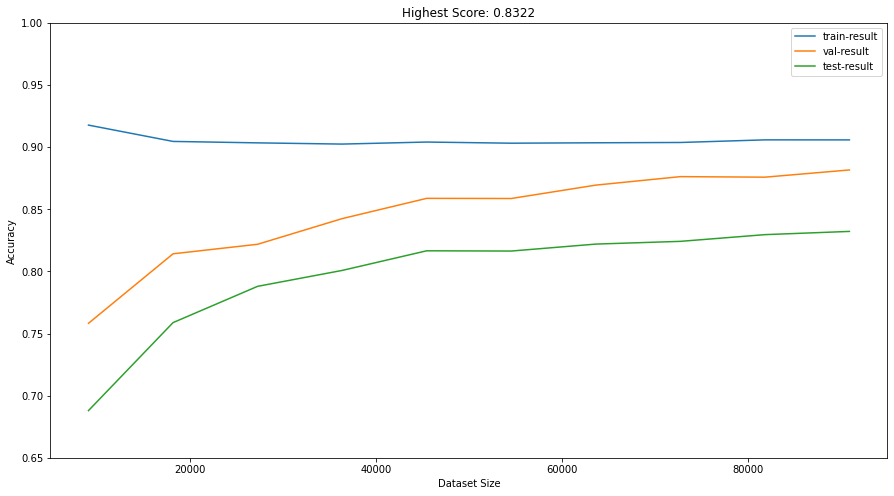

In [79]:
# feature 8: tfidf unibi 50k

xArr, featureModel = feature_tfidfUniBi(tdf1['reviewText'], 50000)
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.9246
Gradient last 3: 0.0007


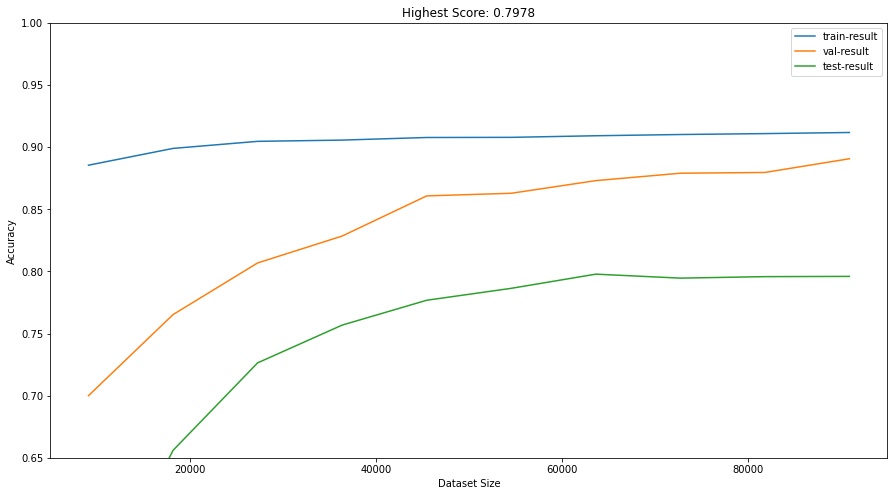

In [80]:
# feature 9: bow uni 100k

xArr, featureModel = feature_bowUni(tdf1['reviewText'], 100000)
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: -0.9405
Gradient last 3: -0.0016


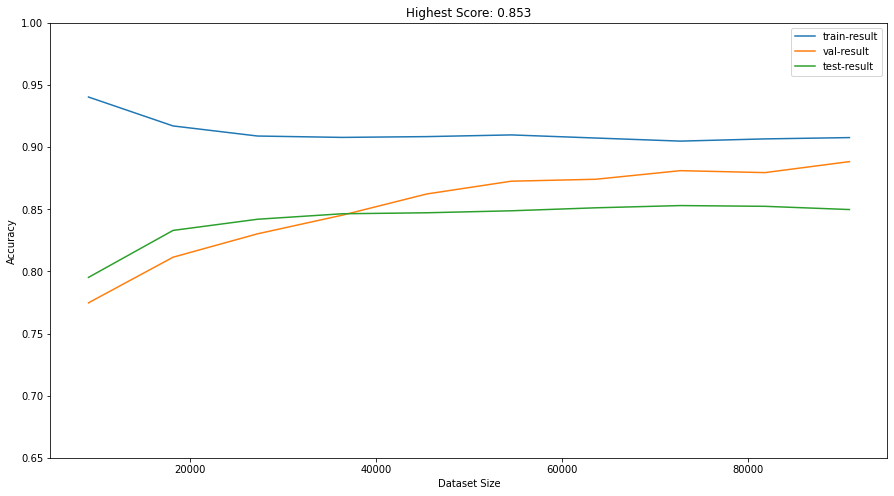

In [81]:
# feature 10: bow unibi 100k

xArr, featureModel = feature_bowUniBi(tdf1['reviewText'], 100000)
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.9984
Gradient last 3: 0.0131


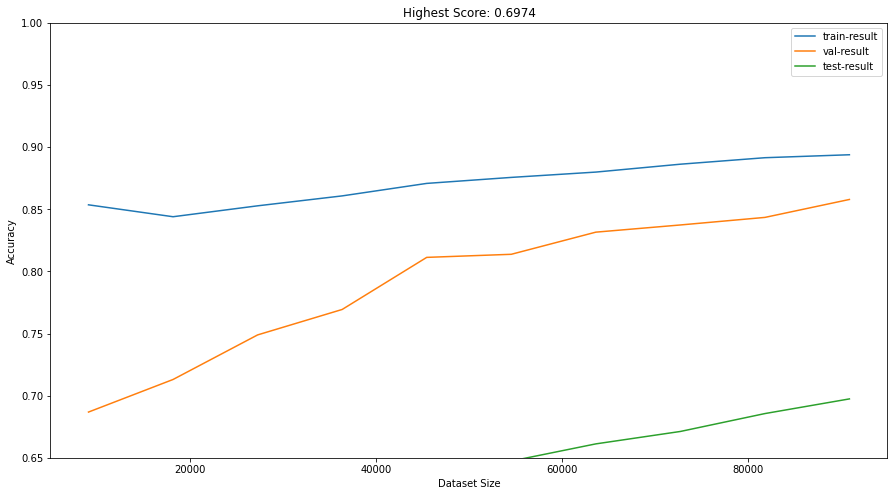

In [82]:
# feature 11: tfidf uni 100k

xArr, featureModel = feature_tfidfUni(tdf1['reviewText'], 100000)
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.9693
Gradient last 3: 0.0025


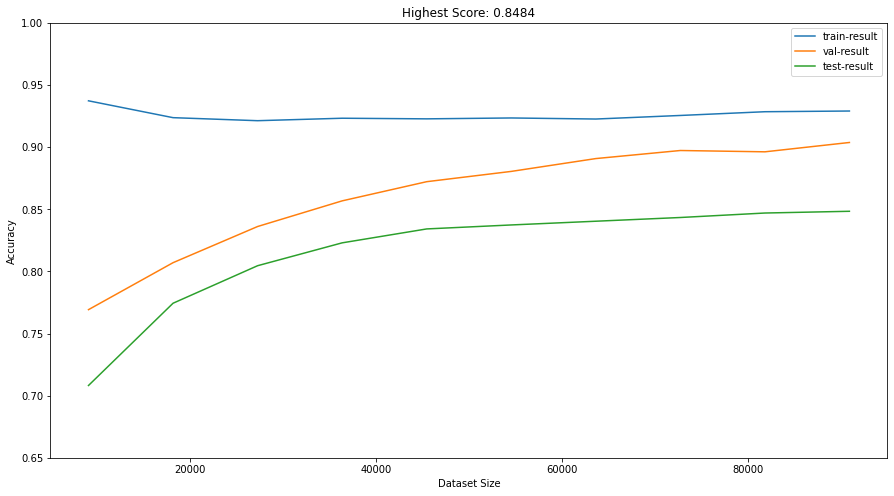

In [83]:
# feature 12: tfidf unibi 100k

xArr, featureModel = feature_tfidfUniBi(tdf1['reviewText'], 100000)
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.8924
Gradient last 3: 0.0016


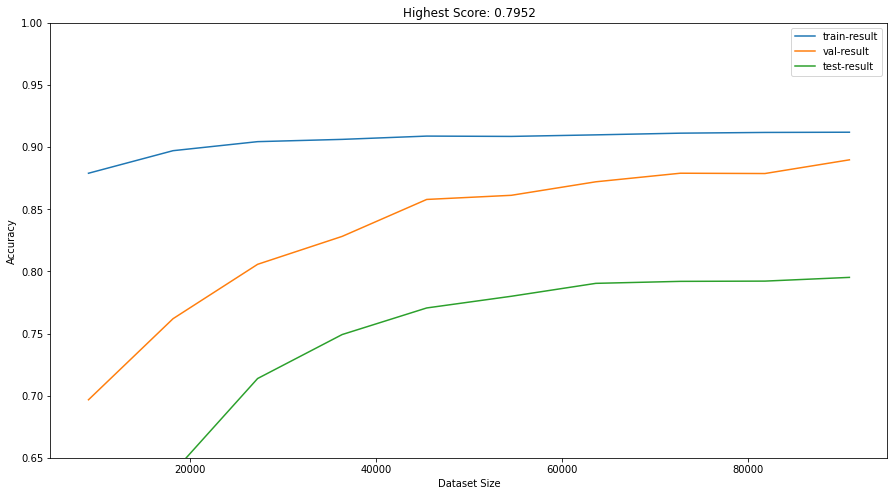

In [84]:
# feature 13: bow uni 150k

xArr, featureModel = feature_bowUni(tdf1['reviewText'], 150000)
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: -0.2405
Gradient last 3: -0.0001


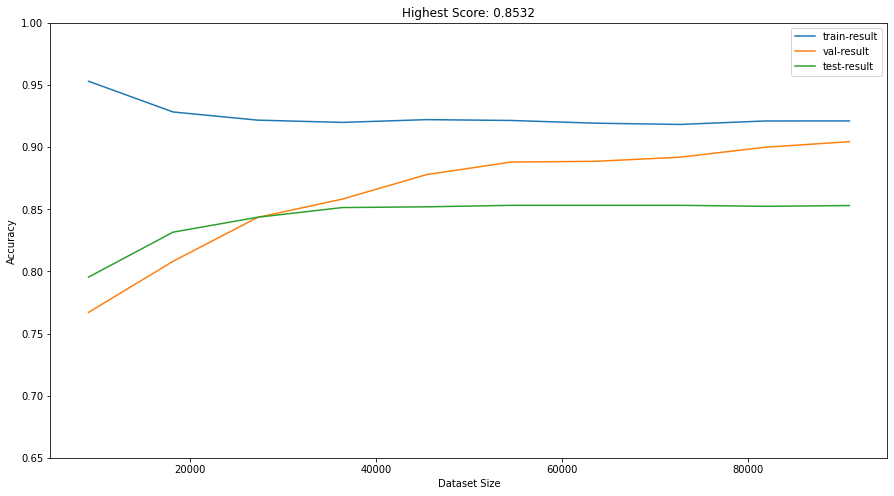

In [85]:
# feature 14: bow unibi 150k

xArr, featureModel = feature_bowUniBi(tdf1['reviewText'], 150000)
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.9979
Gradient last 3: 0.0126


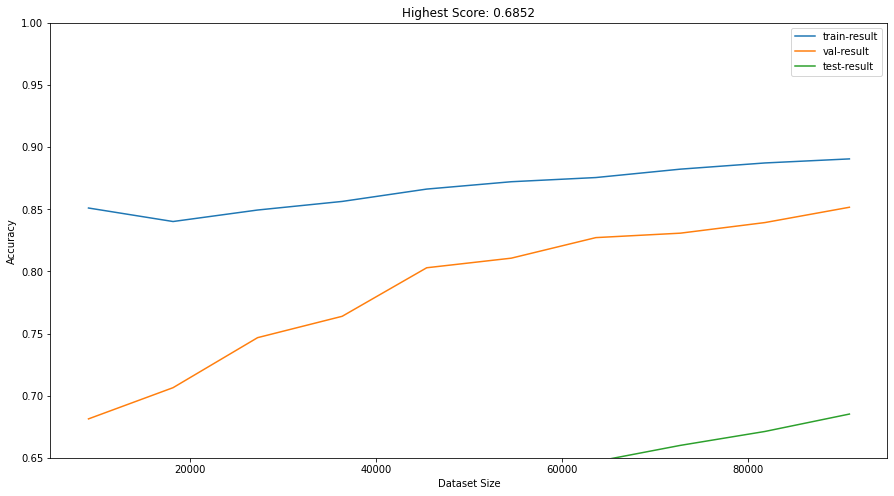

In [86]:
# feature 15: tfidf uni 150k

xArr, featureModel = feature_tfidfUni(tdf1['reviewText'], 150000)
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.9994
Gradient last 3: 0.0034


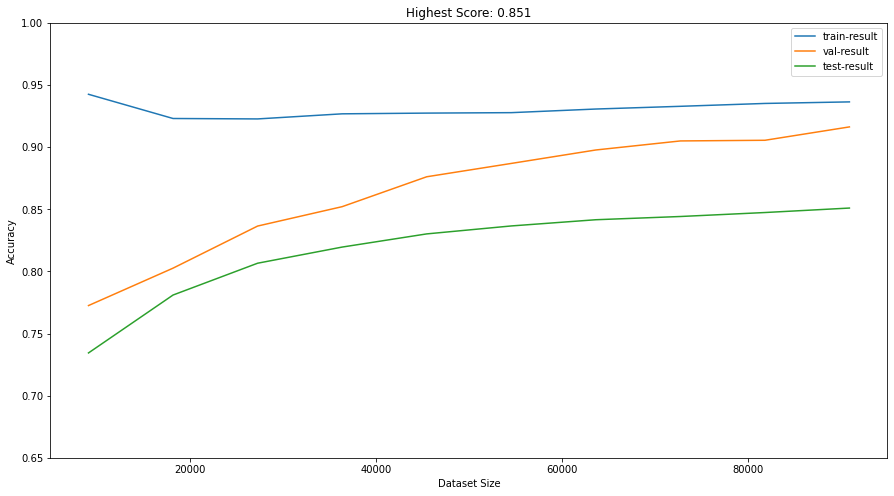

In [87]:
# feature 16: tfidf unibi 150k

xArr, featureModel = feature_tfidfUniBi(tdf1['reviewText'], 150000)
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

In [ ]:
# search for best unibi features max

Result for 25000 max features
Correlation last 3: 0.4706
Gradient last 3: 0.0008


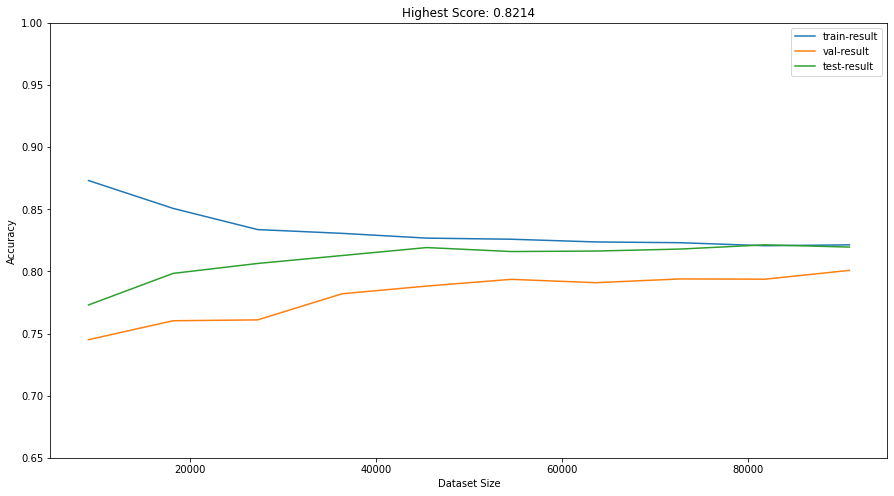

Result for 50000 max features
Correlation last 3: 0.7127
Gradient last 3: 0.0017


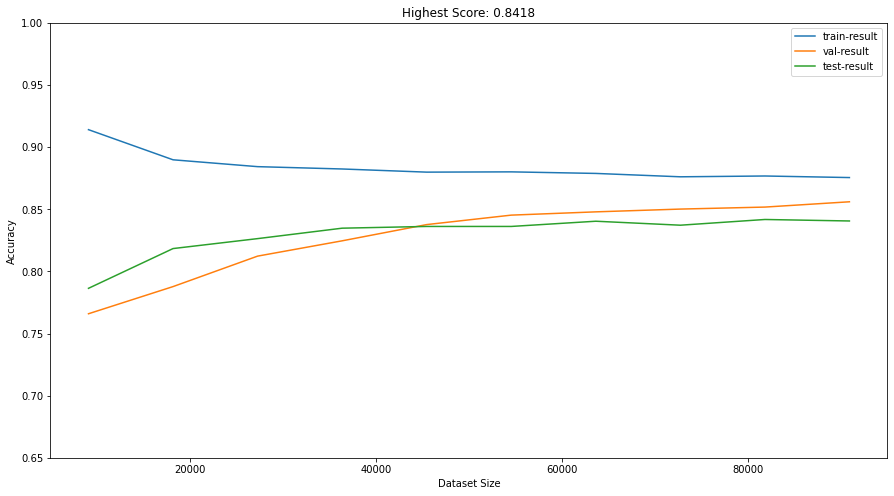

Result for 75000 max features
Correlation last 3: 0.0003
Gradient last 3: -0.0000


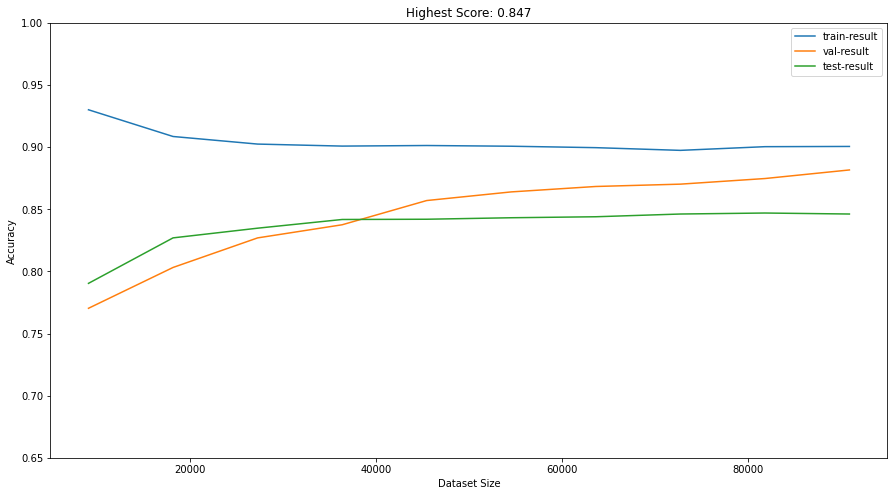

Result for 100000 max features
Correlation last 3: -0.9405
Gradient last 3: -0.0016


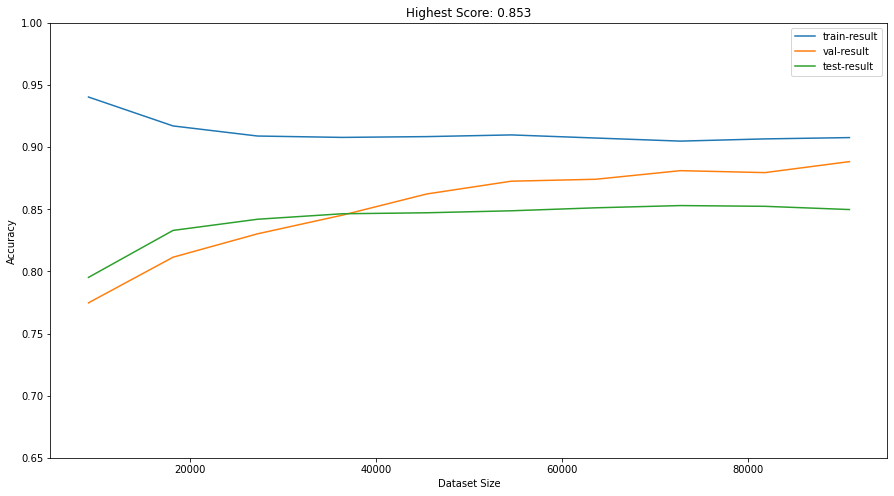

Result for 125000 max features
Correlation last 3: -0.8169
Gradient last 3: -0.0009


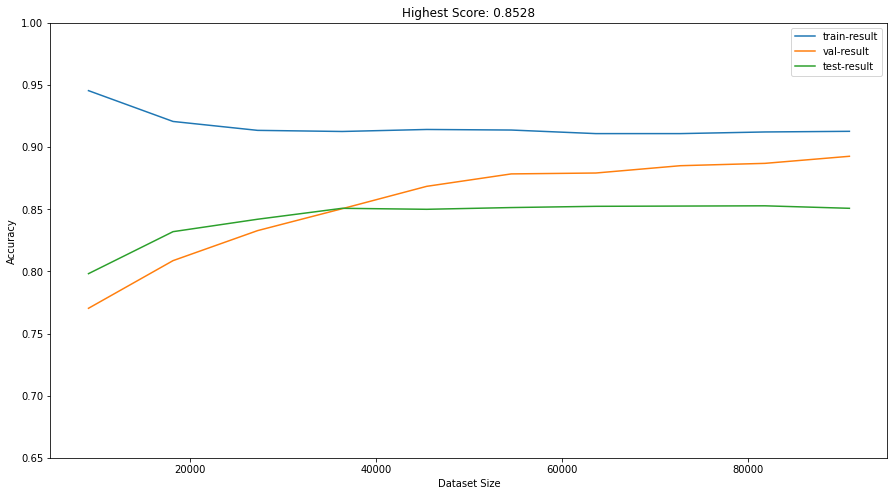

Result for 150000 max features
Correlation last 3: -0.2405
Gradient last 3: -0.0001


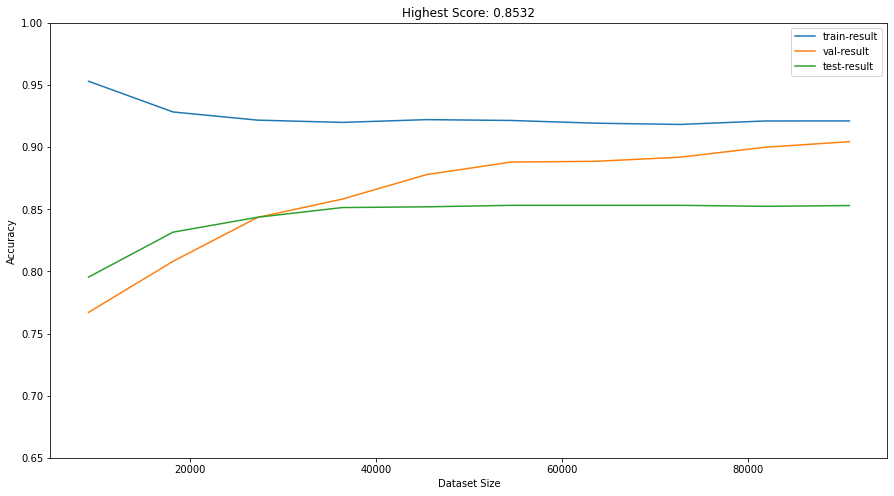

Result for 175000 max features
Correlation last 3: 0.0003
Gradient last 3: -0.0000


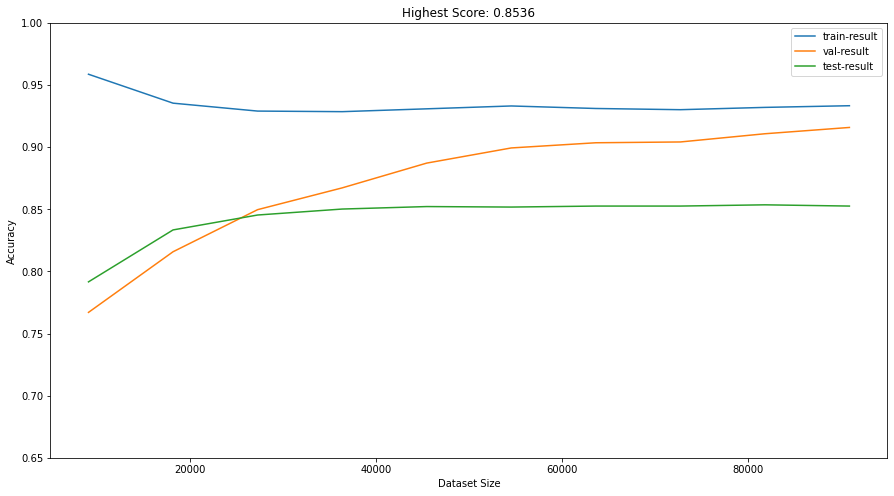

Result for 200000 max features
Correlation last 3: 0.6135
Gradient last 3: 0.0013


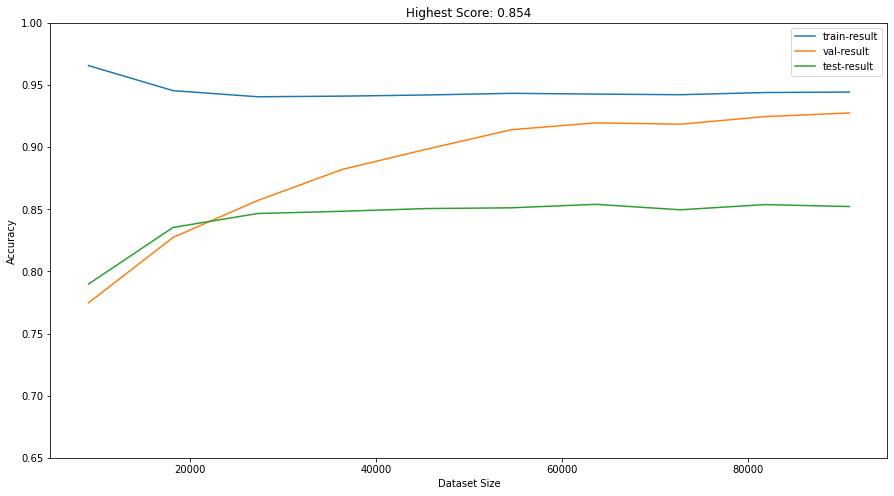

In [88]:
for r in range(25000, 200000+1, 25000):
    xArr, featureModel = feature_bowUniBi(tdf1['reviewText'], r)
    yArr = tdf1['overall'].to_numpy()
    testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
    result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
    print("Result for {} max features".format(r))
    print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
    print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
    visualized_loopTesting(result)

Result for 25000 max features
Correlation last 3: 0.9278
Gradient last 3: 0.0033


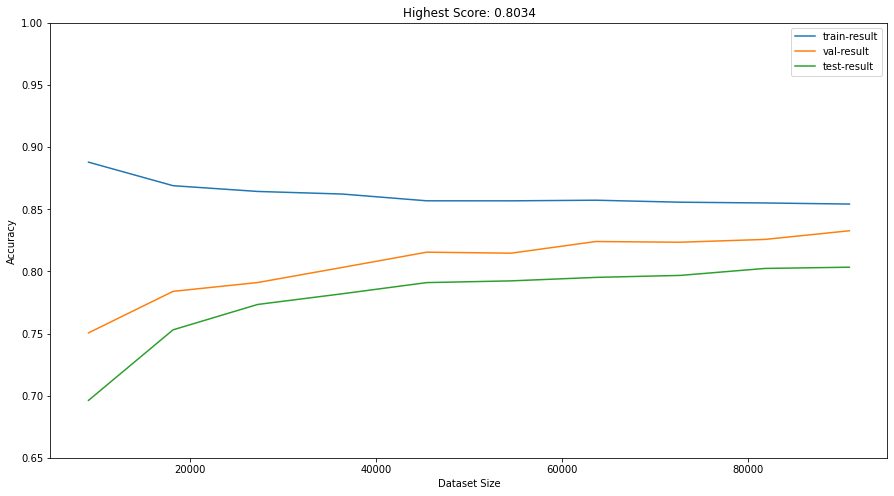

Result for 50000 max features
Correlation last 3: 0.9802
Gradient last 3: 0.0040


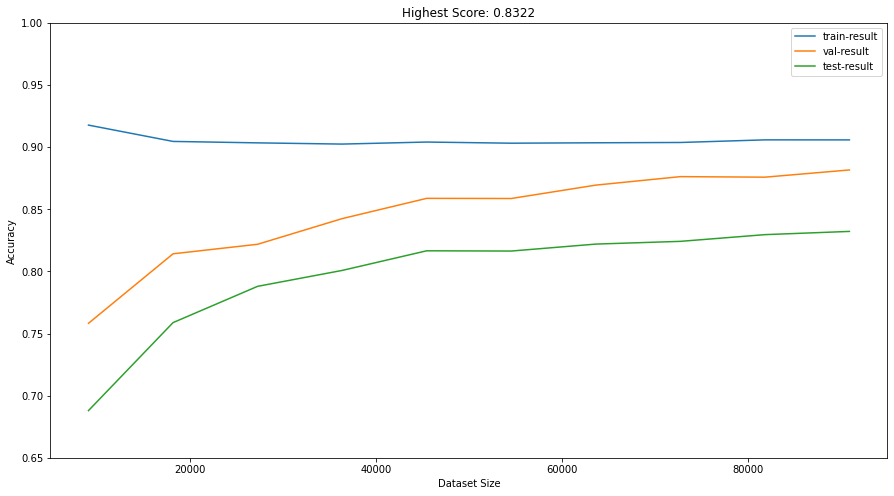

Result for 75000 max features
Correlation last 3: 0.9101
Gradient last 3: 0.0019


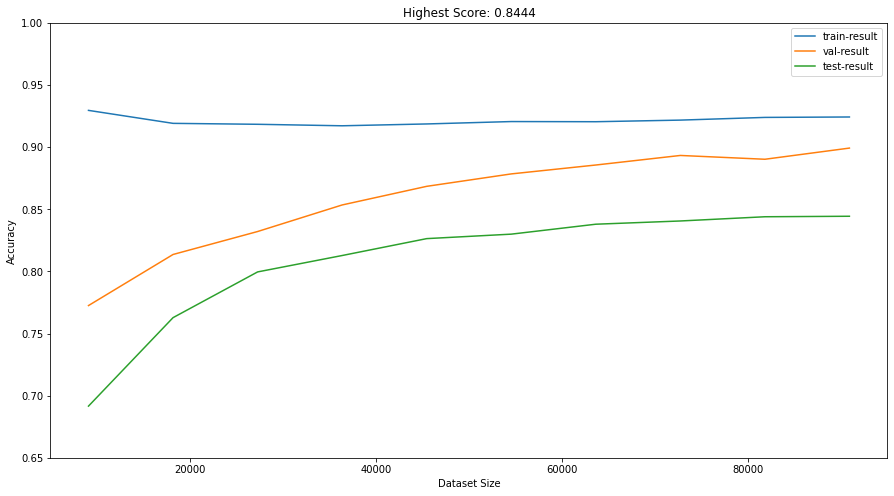

Result for 100000 max features
Correlation last 3: 0.9693
Gradient last 3: 0.0025


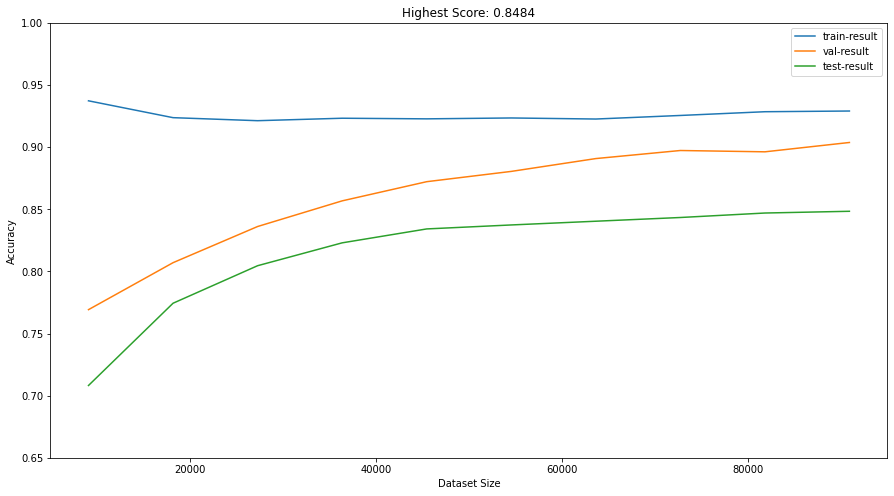

Result for 125000 max features
Correlation last 3: 0.9972
Gradient last 3: 0.0023


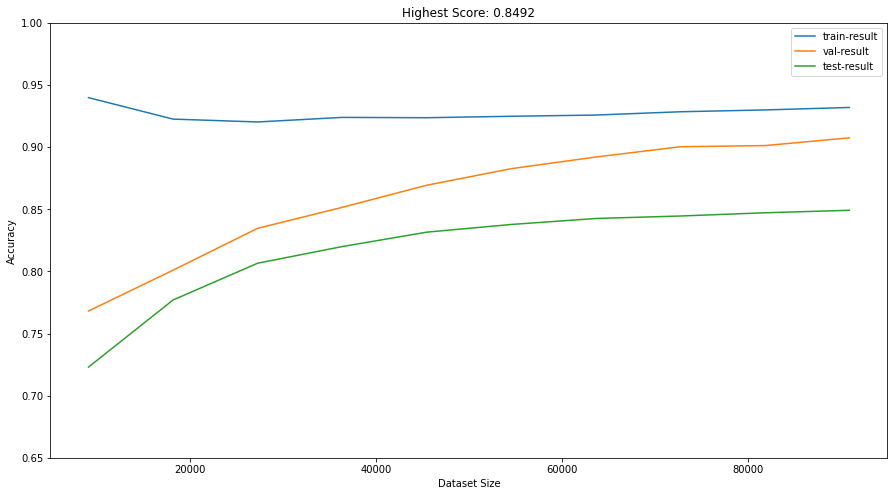

Result for 150000 max features
Correlation last 3: 0.9994
Gradient last 3: 0.0034


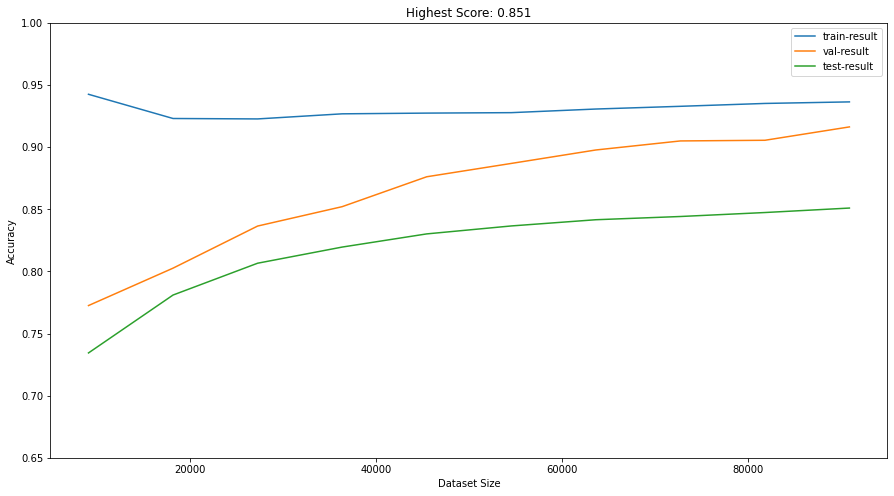

Result for 175000 max features
Correlation last 3: 0.9934
Gradient last 3: 0.0030


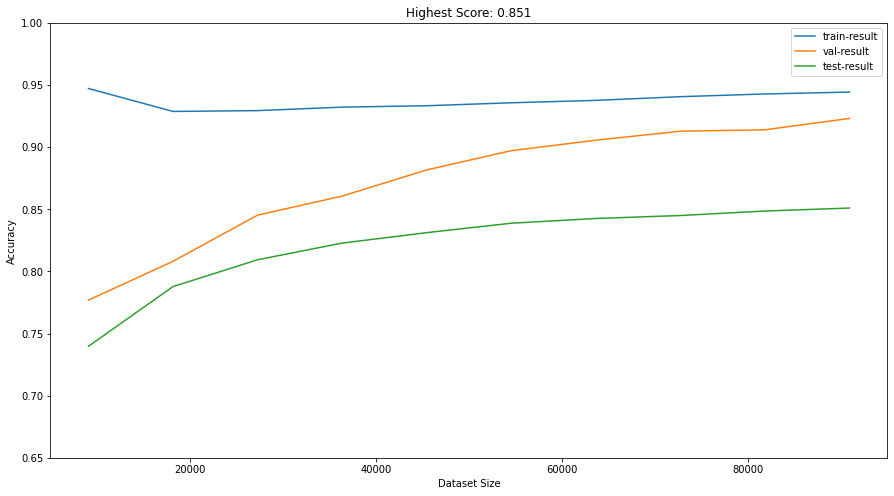

Result for 200000 max features
Correlation last 3: 0.8847
Gradient last 3: 0.0023


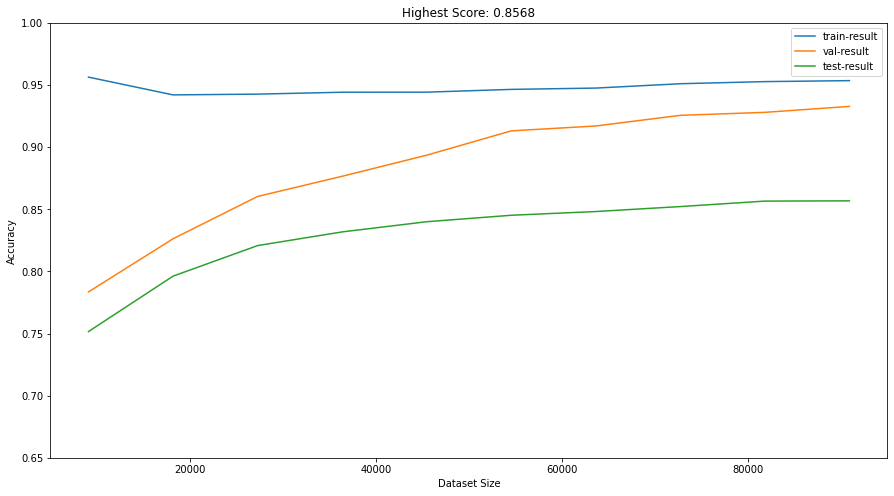

In [89]:
for r in range(25000, 200000+1, 25000):
    xArr, featureModel = feature_tfidfUniBi(tdf1['reviewText'], r)
    yArr = tdf1['overall'].to_numpy()
    testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
    result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
    print("Result for {} max features".format(r))
    print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
    print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
    visualized_loopTesting(result)

In [90]:
# search for best base ml model

In [91]:
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_addPos(txt)
    txt = pipe_normalized(txt, 5, tokenized=True)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))

In [92]:
tdf1.shape

(90921, 3)

In [93]:
tdf2.shape

(5000, 3)

In [95]:
xArr, featureModel = feature_tfidfUniBi(tdf1['reviewText'], 200*1000)
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()

Correlation last 3: 0.8847
Gradient last 3: 0.0023


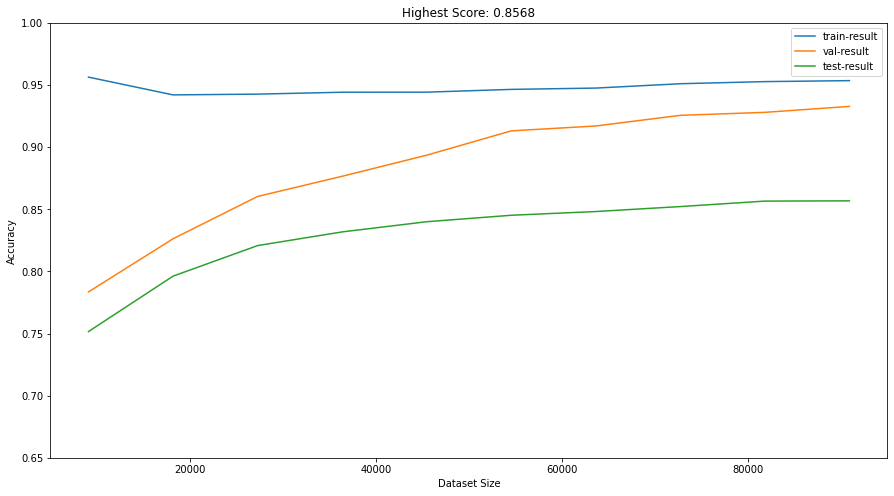

In [96]:
# option 1: naive bayes

nb_model = MultinomialNB()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: -0.0003
Gradient last 3: -0.0000


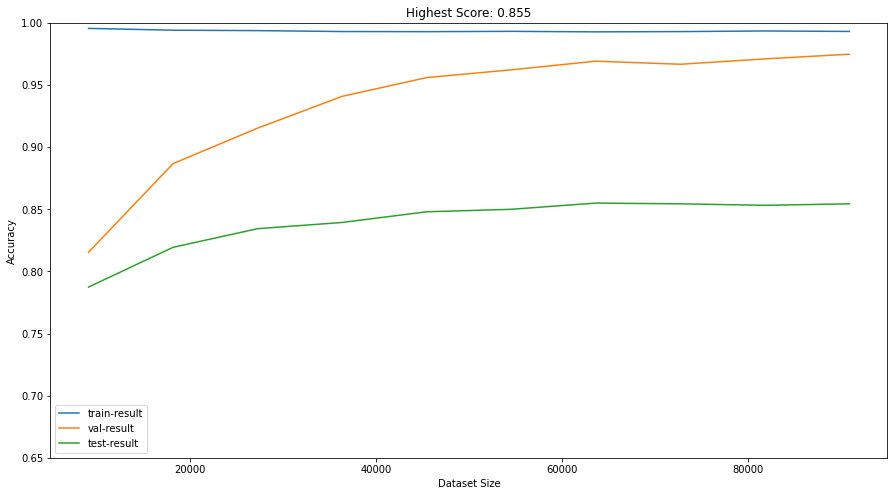

In [97]:
# option 2: linear svc

svc_model = LinearSVC()
result = loop_testing(svc_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.9998
Gradient last 3: 0.0031


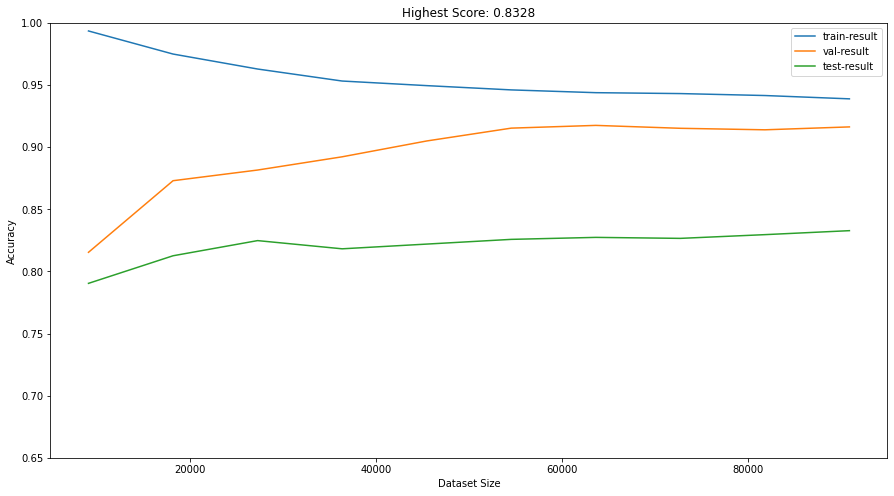

In [100]:
# option 3: linear sgd

sgd_model = SGDClassifier()
result = loop_testing(sgd_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.5850
Gradient last 3: 0.0020


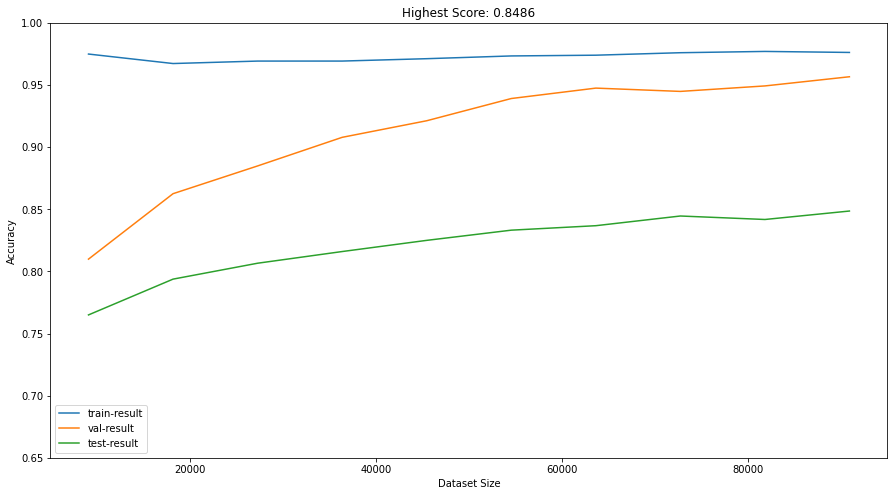

In [99]:
# option 4: linear logistic

log_model = LogisticRegression()
result = loop_testing(log_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Iteration 1, loss = 1.04059259
Validation score: 0.743590
Iteration 2, loss = 0.67730229
Validation score: 0.771673
Iteration 3, loss = 0.34116560
Validation score: 0.778999
Iteration 4, loss = 0.17284313
Validation score: 0.782662
Iteration 5, loss = 0.10035722
Validation score: 0.780220
Iteration 6, loss = 0.06671756
Validation score: 0.780220
Iteration 7, loss = 0.04896190
Validation score: 0.775336
Iteration 8, loss = 0.03857997
Validation score: 0.775336
Iteration 9, loss = 0.03203822
Validation score: 0.774115
Iteration 10, loss = 0.02748647
Validation score: 0.774115
Iteration 11, loss = 0.02429716
Validation score: 0.776557
Iteration 12, loss = 0.02199647
Validation score: 0.774115
Iteration 13, loss = 0.02021468
Validation score: 0.776557
Iteration 14, loss = 0.01892579
Validation score: 0.775336
Iteration 15, loss = 0.01776063
Validation score: 0.774115
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.92777388


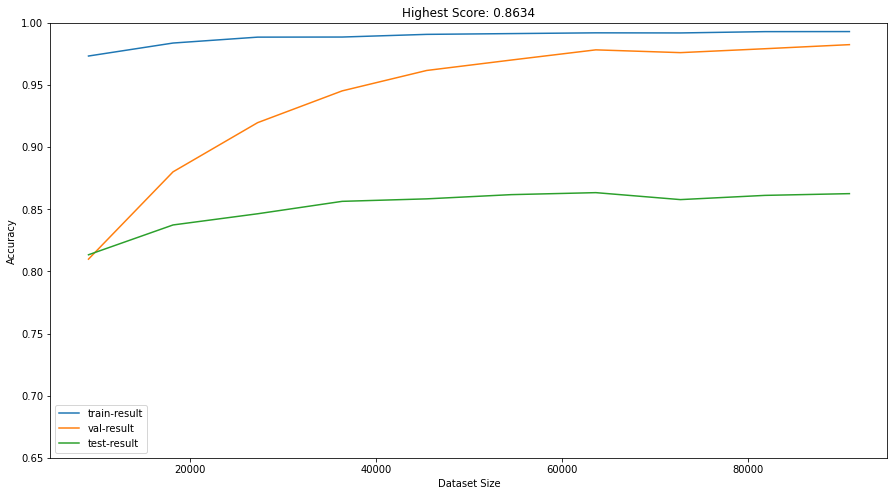

In [101]:
# option 4: snn

mlp_model = MLPClassifier(verbose=True, early_stopping=True)
result = loop_testing(mlp_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

In [103]:
# no search on hyperparameter since its a snn, tuning would be done in later stage

In [105]:
# train whole data

In [104]:
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_addPos(txt)
    txt = pipe_normalized(txt, 5, tokenized=True)
    return txt

tdf1 = dfdataTrain.copy()
tdf2 = dfdataTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))

In [106]:
xArr, featureModel = feature_tfidfUniBi(tdf1['reviewText'], 200000)
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()

In [107]:
mlp_model = MLPClassifier(verbose=True, early_stopping=True, tol=1e-5)
mlp_model.fit(xArr, yArr)

Iteration 1, loss = 0.35644978
Validation score: 0.888222
Iteration 2, loss = 0.20374616
Validation score: 0.880067
Iteration 3, loss = 0.11502344
Validation score: 0.871867
Iteration 4, loss = 0.06829608
Validation score: 0.867000
Iteration 5, loss = 0.05144097
Validation score: 0.863289
Iteration 6, loss = 0.05109836
Validation score: 0.866556
Iteration 7, loss = 0.04734096
Validation score: 0.866867
Iteration 8, loss = 0.04133951
Validation score: 0.864289
Iteration 9, loss = 0.03919829
Validation score: 0.864356
Iteration 10, loss = 0.04004211
Validation score: 0.865289
Iteration 11, loss = 0.03735291
Validation score: 0.862822
Iteration 12, loss = 0.03551956
Validation score: 0.865222
Validation score did not improve more than tol=0.000010 for 10 consecutive epochs. Stopping.


MLPClassifier(early_stopping=True, tol=1e-05, verbose=True)

              precision    recall  f1-score   support

    Positive       0.97      0.92      0.94     40095
     Neutral       0.16      0.47      0.24      1242
    Negative       0.81      0.79      0.80      8663

    accuracy                           0.89     50000
   macro avg       0.65      0.73      0.66     50000
weighted avg       0.92      0.89      0.90     50000



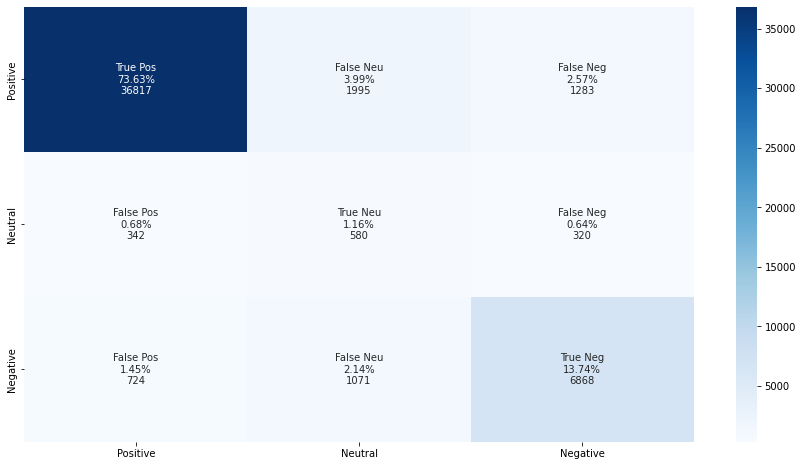

In [108]:
yHat = mlp_model.predict(testXArr)
show_result(yHat, testYArr)

In [ ]:
# 0.89, that the best one so far